In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

/tmp/ipykernel_3401815/2693994187.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Simulate the Lorenz system

The Lorenz system is a system of ordinary differential equations first studied by Edward Lorenz. It is notable for having chaotic solutions for certain parameter values and initial conditions. In particular, the Lorenz attractor is a set of chaotic solutions of the Lorenz system which, when plotted, resemble a butterfly or figure eight.

The Lorenz system is given by the following differential equations:

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $x$, $y$, and $z$ are the state variables, and $\sigma$, $\rho$, and $\beta$ are the system parameters.


In [2]:
def lorenz_system(state, t, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Generate data using odeint
np.random.seed(0)
torch.manual_seed(0)
t = np.linspace(0, 200, 5000)  # Time vector
initial_state = [1.0, 1.0, 1.0]
lorenz_data = odeint(lorenz_system, initial_state, t)

# Do a 60, 20, 20 split for training, validation, and testing
train_data = lorenz_data[:int(0.6 * len(lorenz_data))]
val_data = lorenz_data[int(0.6 * len(lorenz_data)):int(0.8 * len(lorenz_data))]
test_data = lorenz_data[int(0.8 * len(lorenz_data)):]

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)


# Create a custom dataset for the Lorenz system

In this notebook, we will create a custom dataset for the Lorenz system. We will simulate the Lorenz system for a given set of parameters and initial conditions, and then use the simulated data to train a neural network to predict the future state of the system. In this case the history will just be the current state, but this can be easily extended to include more history using the `sequence_length` parameter from above.

In [3]:
# Custom Dataset Class
class LorenzDataset(Dataset):
    def __init__(self, data, sequence_length, in_vars=[1], out_vars=[0, 2]):
        self.data = data
        self.sequence_length = sequence_length
        self.in_vars = in_vars
        self.out_vars = out_vars

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length, self.in_vars] 
        y = self.data[idx + self.sequence_length, self.out_vars]
        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

sequence_length = 16
train_dataset = LorenzDataset(train_data, sequence_length)
val_dataset = LorenzDataset(val_data, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Define our model structures

We will compare a simple feedforward neural network/multilayer perceptron (MLP) with a recurrent neural network (RNN) to predict the future state of the Lorenz system. Both models will take some past history of two of the three variables as input and predict the third one as the output.

In [4]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, output_size=2, hidden_size=16, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden = None

    def forward(self, x, hidden=None):
        out, self.hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Only use the output at the last time step
        return out

class MLPModel(nn.Module):
    def __init__(self, input_size=sequence_length*1, output_size=2, hidden_size=16):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        o, (h, c) = self.lstm(x)
        return self.fc(o)[:, -1, :]

# Create the training routine

The function below will train the model on the simulated data and return the training and validation metrics. This is a standard training routine that can be used for many neural network models & datasets.

In [5]:
def train_model(model, optimizer, train_loader, val_loader, loss_fn, device, n_epochs=100):
    all_train_loss = []
    all_val_loss = []
    model.train()
    for epoch in range(n_epochs):
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        all_train_loss.append(train_loss / len(train_loader))
        
        # Validation after each epoch
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_pred = model(x_val)
                val_loss += loss_fn(y_pred, y_val).item()
        val_loss /= len(val_loader)
        all_val_loss.append(val_loss)
        print(f"Epoch [{epoch+1}/{n_epochs}], Val Loss: {val_loss:.4f}")
        model.train()
    return pd.DataFrame({
        'train_loss': all_train_loss, 
        'val_loss': all_val_loss
    })


# Create our models, loss function, and optimizers

The models from above are initialized here, and we also define the loss function and optimizer for training the models. This is set up in a fairly standard way, with the mean squared error loss and the Adam optimizer.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 8
rnn_model = RNNModel(input_size=1, output_size=2, hidden_size=hidden_size).to(device)
mlp_model = MLPModel(input_size=sequence_length, output_size=2, hidden_size=hidden_size).to(device)

loss_fn = nn.MSELoss()
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=0.001)
mlp_optimizer = optim.AdamW(mlp_model.parameters(), lr=0.001)


In [7]:
print("Training RNN...")
rnn_loss_df = train_model(rnn_model, rnn_optimizer, train_loader, val_loader, loss_fn, device)

Training RNN...
Epoch [1/100], Val Loss: 0.1789
Epoch [2/100], Val Loss: 0.1710
Epoch [3/100], Val Loss: 0.1633
Epoch [4/100], Val Loss: 0.1540
Epoch [5/100], Val Loss: 0.1385
Epoch [6/100], Val Loss: 0.1101
Epoch [7/100], Val Loss: 0.0801
Epoch [8/100], Val Loss: 0.0707
Epoch [9/100], Val Loss: 0.0654
Epoch [10/100], Val Loss: 0.0601
Epoch [11/100], Val Loss: 0.0540
Epoch [12/100], Val Loss: 0.0472
Epoch [13/100], Val Loss: 0.0408
Epoch [14/100], Val Loss: 0.0355
Epoch [15/100], Val Loss: 0.0310
Epoch [16/100], Val Loss: 0.0274
Epoch [17/100], Val Loss: 0.0244
Epoch [18/100], Val Loss: 0.0219
Epoch [19/100], Val Loss: 0.0196
Epoch [20/100], Val Loss: 0.0176
Epoch [21/100], Val Loss: 0.0158
Epoch [22/100], Val Loss: 0.0142
Epoch [23/100], Val Loss: 0.0127
Epoch [24/100], Val Loss: 0.0112
Epoch [25/100], Val Loss: 0.0100
Epoch [26/100], Val Loss: 0.0086
Epoch [27/100], Val Loss: 0.0072
Epoch [28/100], Val Loss: 0.0062
Epoch [29/100], Val Loss: 0.0052
Epoch [30/100], Val Loss: 0.0045
Epo

In [8]:
print("Training MLP...")
mlp_loss_df = train_model(mlp_model, mlp_optimizer, train_loader, val_loader, loss_fn, device)

Training MLP...
Epoch [1/100], Val Loss: 0.1681
Epoch [2/100], Val Loss: 0.1419
Epoch [3/100], Val Loss: 0.1233
Epoch [4/100], Val Loss: 0.1067
Epoch [5/100], Val Loss: 0.0913
Epoch [6/100], Val Loss: 0.0772
Epoch [7/100], Val Loss: 0.0646
Epoch [8/100], Val Loss: 0.0544
Epoch [9/100], Val Loss: 0.0461
Epoch [10/100], Val Loss: 0.0394
Epoch [11/100], Val Loss: 0.0340
Epoch [12/100], Val Loss: 0.0298
Epoch [13/100], Val Loss: 0.0264
Epoch [14/100], Val Loss: 0.0237
Epoch [15/100], Val Loss: 0.0215
Epoch [16/100], Val Loss: 0.0197
Epoch [17/100], Val Loss: 0.0182
Epoch [18/100], Val Loss: 0.0169
Epoch [19/100], Val Loss: 0.0158
Epoch [20/100], Val Loss: 0.0147
Epoch [21/100], Val Loss: 0.0138
Epoch [22/100], Val Loss: 0.0128
Epoch [23/100], Val Loss: 0.0119
Epoch [24/100], Val Loss: 0.0110
Epoch [25/100], Val Loss: 0.0102
Epoch [26/100], Val Loss: 0.0094
Epoch [27/100], Val Loss: 0.0087
Epoch [28/100], Val Loss: 0.0080
Epoch [29/100], Val Loss: 0.0074
Epoch [30/100], Val Loss: 0.0068
Epo

[]

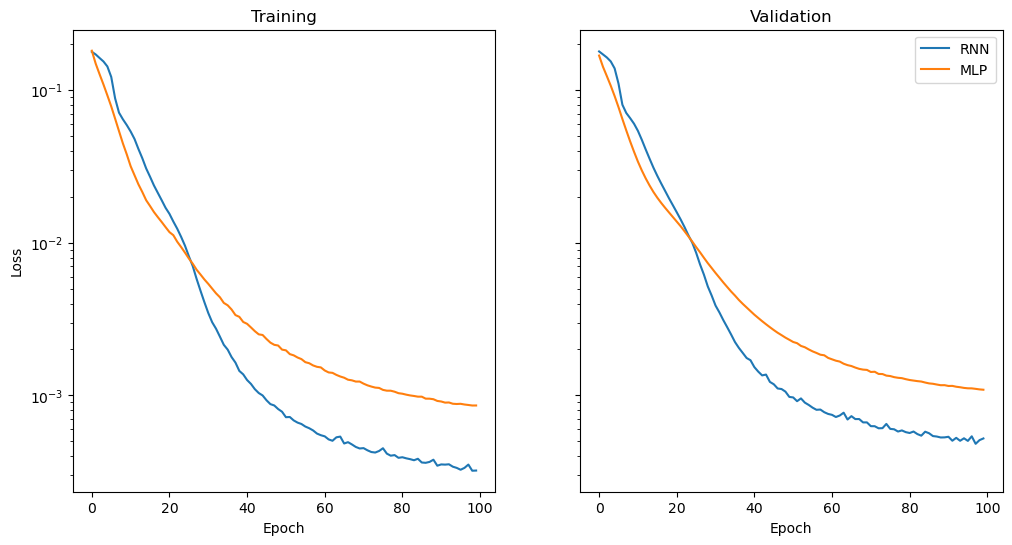

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

rnn_loss_df['train_loss'].plot(ax=axes[0], title='Training')
mlp_loss_df['train_loss'].plot(ax=axes[0], title='Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

rnn_loss_df['val_loss'].plot(ax=axes[1], title='Validation')
mlp_loss_df['val_loss'].plot(ax=axes[1], title='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

axes[1].legend(['RNN', 'MLP'])
axes[0].semilogy()
axes[1].semilogy()


In [10]:
def generate_predictions(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_pred = model(x_batch)
            predictions.append(y_pred.cpu().numpy())
    return np.concatenate(predictions)

rnn_predictions = generate_predictions(rnn_model, val_loader)
mlp_predictions = generate_predictions(mlp_model, val_loader)

Text(0.5, 0, 'Time')

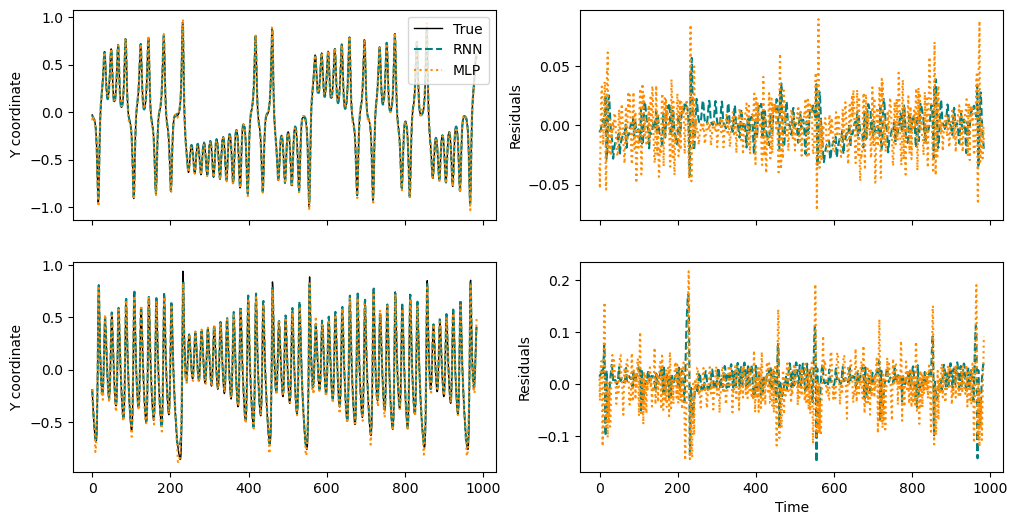

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
axes = axes.flatten()

ax = axes[0]
ax.plot(val_data[sequence_length:, 0], label='True', linewidth=1, color='black')
ax.plot(rnn_predictions[:, 0], label='RNN', color='teal', linestyle='--')
ax.plot(mlp_predictions[:, 0], label='MLP', color='darkorange', linestyle=':')

ax.legend()
ax.set_ylabel('Y coordinate')

ax = axes[1]
# plot residuals
rnn_residuals = rnn_predictions[:, 0] - val_data[sequence_length:, 0]
mlp_residuals = mlp_predictions[:, 0] - val_data[sequence_length:, 0]
ax.plot(rnn_residuals, label='RNN', color='teal', linestyle='--')
ax.plot(mlp_residuals, label='MLP', color='darkorange', linestyle=':')
ax.set_ylabel('Residuals')

ax = axes[2]
ax.plot(val_data[sequence_length:, -1], label='True', linewidth=1, color='black')
ax.plot(rnn_predictions[:, -1], label='RNN', color='teal', linestyle='--')
ax.plot(mlp_predictions[:, -1], label='MLP', color='darkorange', linestyle=':')

ax.set_ylabel('Y coordinate')

ax = axes[3]
# plot residuals
rnn_residuals = rnn_predictions[:, -1] - val_data[sequence_length:, -1]
mlp_residuals = mlp_predictions[:, -1] - val_data[sequence_length:, -1]
ax.plot(rnn_residuals, label='RNN', color='teal', linestyle='--')
ax.plot(mlp_residuals, label='MLP', color='darkorange', linestyle=':')
ax.set_ylabel('Residuals')



ax.set_xlabel('Time')